In [1]:
# Copyright 2025 Bytedance Ltd. and/or its affiliates.
# SPDX-License-Identifier: Apache-2.0

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from copy import deepcopy
from typing import (
    Any,
    AsyncIterable,
    Callable,
    Dict,
    Generator,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union,
)
import requests
from io import BytesIO

from PIL import Image
import torch
from accelerate import infer_auto_device_map, load_checkpoint_and_dispatch, init_empty_weights

from data.transforms import ImageTransform
from data.data_utils import pil_img2rgb, add_special_tokens
from modeling.bagel import (
    BagelConfig, Bagel, Qwen2Config, Qwen2ForCausalLM, SiglipVisionConfig, SiglipVisionModel
)
from modeling.qwen2 import Qwen2Tokenizer
from modeling.bagel.qwen2_navit import NaiveCache
from modeling.autoencoder import load_ae
from safetensors.torch import load_file

/home/amitakamath/miniconda/envs/bagel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Initialization

In [4]:
from huggingface_hub import snapshot_download
save_dir = "/checkpoint/dream/transfusion/cache/BAGEL-7B-MoT"
repo_id = "ByteDance-Seed/BAGEL-7B-MoT"
cache_dir = save_dir + "/cache"

snapshot_download(cache_dir=cache_dir,
  local_dir=save_dir,
  repo_id=repo_id,
  local_dir_use_symlinks=False,
  resume_download=True,
  allow_patterns=["*.json", "*.safetensors", "*.bin", "*.py", "*.md", "*.txt"],
)
model_path = save_dir  # Download from https://huggingface.co/ByteDance-Seed/BAGEL-7B-MoT

# LLM config preparing
llm_config = Qwen2Config.from_json_file(os.path.join(model_path, "llm_config.json"))
llm_config.qk_norm = True
llm_config.tie_word_embeddings = False
llm_config.layer_module = "Qwen2MoTDecoderLayer"

# ViT config preparing
vit_config = SiglipVisionConfig.from_json_file(os.path.join(model_path, "vit_config.json"))
vit_config.rope = False
vit_config.num_hidden_layers = vit_config.num_hidden_layers - 1

# VAE loading
vae_model, vae_config = load_ae(local_path=os.path.join(model_path, "ae.safetensors"))

# Bagel config preparing
config = BagelConfig(
    visual_gen=True,
    visual_und=True,
    llm_config=llm_config, 
    vit_config=vit_config,
    vae_config=vae_config,
    vit_max_num_patch_per_side=70,
    connector_act='gelu_pytorch_tanh',
    latent_patch_size=2,
    max_latent_size=64,
)

with init_empty_weights():
    language_model = Qwen2ForCausalLM(llm_config)
    vit_model      = SiglipVisionModel(vit_config)
    model          = Bagel(language_model, vit_model, config)
    model.vit_model.vision_model.embeddings.convert_conv2d_to_linear(vit_config, meta=True)

# Tokenizer Preparing
tokenizer = Qwen2Tokenizer.from_pretrained(model_path)
tokenizer, new_token_ids, _ = add_special_tokens(tokenizer)

# Image Transform Preparing
vae_transform = ImageTransform(1024, 512, 16)
vit_transform = ImageTransform(980, 224, 14)

Fetching 12 files:   0%|                                                                                                                                                                     | 0/12 [00:00<?, ?it/s]/home/amitakamath/miniconda/envs/bagel/lib/python3.10/site-packages/huggingface_hub/file_download.py:834: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
/home/amitakamath/miniconda/envs/bagel/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


## Model Loading and Multi GPU Infernece Preparing

In [5]:
max_mem_per_gpu = "80GiB"  # Modify it according to your GPU setting. On an A100, 80 GiB is sufficient to load on a single GPU.

device_map = infer_auto_device_map(
    model,
    max_memory={i: max_mem_per_gpu for i in range(torch.cuda.device_count())},
    no_split_module_classes=["Bagel", "Qwen2MoTDecoderLayer"],
)
print(device_map)

same_device_modules = [
    'language_model.model.embed_tokens',
    'time_embedder',
    'latent_pos_embed',
    'vae2llm',
    'llm2vae',
    'connector',
    'vit_pos_embed'
]

if torch.cuda.device_count() == 1:
    first_device = device_map.get(same_device_modules[0], "cuda:0")
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device
        else:
            device_map[k] = "cuda:0"
else:
    first_device = device_map.get(same_device_modules[0])
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device

# Thanks @onion-liu: https://github.com/ByteDance-Seed/Bagel/pull/8
model = load_checkpoint_and_dispatch(
    model,
    checkpoint=os.path.join(model_path, "ema.safetensors"),
    device_map=device_map,
    offload_buffers=True,
    dtype=torch.bfloat16,
    force_hooks=True,
    offload_folder="/tmp/offload"
)

model = model.eval()
print('Model loaded')

The safetensors archive passed at /checkpoint/dream/transfusion/cache/BAGEL-7B-MoT/ema.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


OrderedDict([('', 0)])


Model loaded


## Inferencer Preparing 

In [6]:
from inferencer import InterleaveInferencer

inferencer = InterleaveInferencer(
    model=model, 
    vae_model=vae_model, 
    tokenizer=tokenizer, 
    vae_transform=vae_transform, 
    vit_transform=vit_transform, 
    new_token_ids=new_token_ids
)

In [7]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**About Inference Hyperparameters:**
- **`cfg_text_scale`:** Controls how strongly the model follows the text prompt. `1.0` disables text guidance. Typical range: `4.0–8.0`.
- **`cfg_image_scale`:** Controls how much the model preserves input image details. `1.0` disables image guidance. Typical range: `1.0–2.0`.
- **`cfg_interval`:** Fraction of denoising steps where CFG is applied. Later steps can skip CFG to reduce computation. Typical: `[0.4, 1.0]`.
- **`timestep_shift`:** Shifts the distribution of denoising steps. Higher values allocate more steps at the start (affects layout); lower values allocate more at the end (improves details).
- **`num_timesteps`:** Total denoising steps. Typical: `50`.
- **`cfg_renorm_min`:** Minimum value for CFG-Renorm. `1.0` disables renorm. Typical: `0`.
- **`cfg_renorm_type`:** CFG-Renorm method:  
  - `global`: Normalize over all tokens and channels (default for T2I).
  - `channel`: Normalize across channels for each token.
  - `text_channel`: Like `channel`, but only applies to text condition (good for editing, may cause blur).
- **If edited images appear blurry, try `global` CFG-Renorm, decrease `cfg_renorm_min` or decrease `cfg_scale`.**


## Image Generation

In [15]:
inference_hyper=dict(
    cfg_text_scale=4.0,
    cfg_img_scale=1.0,
    cfg_interval=[0.4, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="global",
)

a photo of a ball
----------


  0%|                                                                                                                                                                                        | 0/49 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.15it/s]


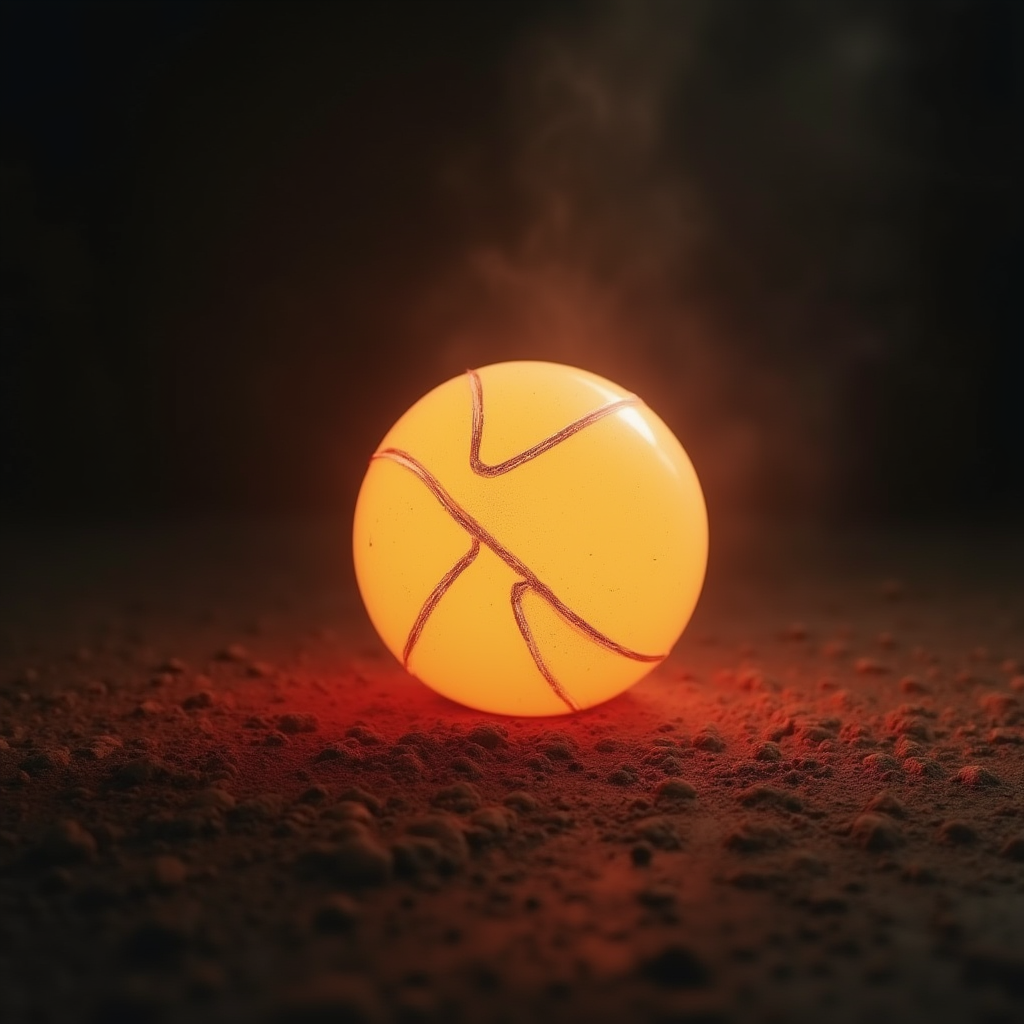

In [16]:
# "Stress test" with increasingly complex prompts
prompts = [
    "a photo of a ball"
]

for prompt in prompts:
    print(prompt)
    print('-' * 10)
    output_dict = inferencer(text=prompt, **inference_hyper)
    display(output_dict['image'])

## Image Generation with Think

In [12]:
inference_hyper=dict(
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=1.0,
    cfg_interval=[0.4, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="global",
)

a photo of a ball
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.13it/s]


<think>
The model should generate an image of a spherical object, such as a ball, with a smooth and uniform surface.
Here’s the expanded prompt: A highly detailed and realistic image of a perfectly spherical ball with a smooth and uniform surface, rendered in ultra-realistic detail. The ball is centered in the frame, with soft, even lighting that highlights its glossy texture and subtle reflections. The background is minimal and neutral, ensuring the ball remains the sole focus. The atmosphere is clean and modern, with no distractions, emphasizing the simplicity and elegance of the object.
</think>


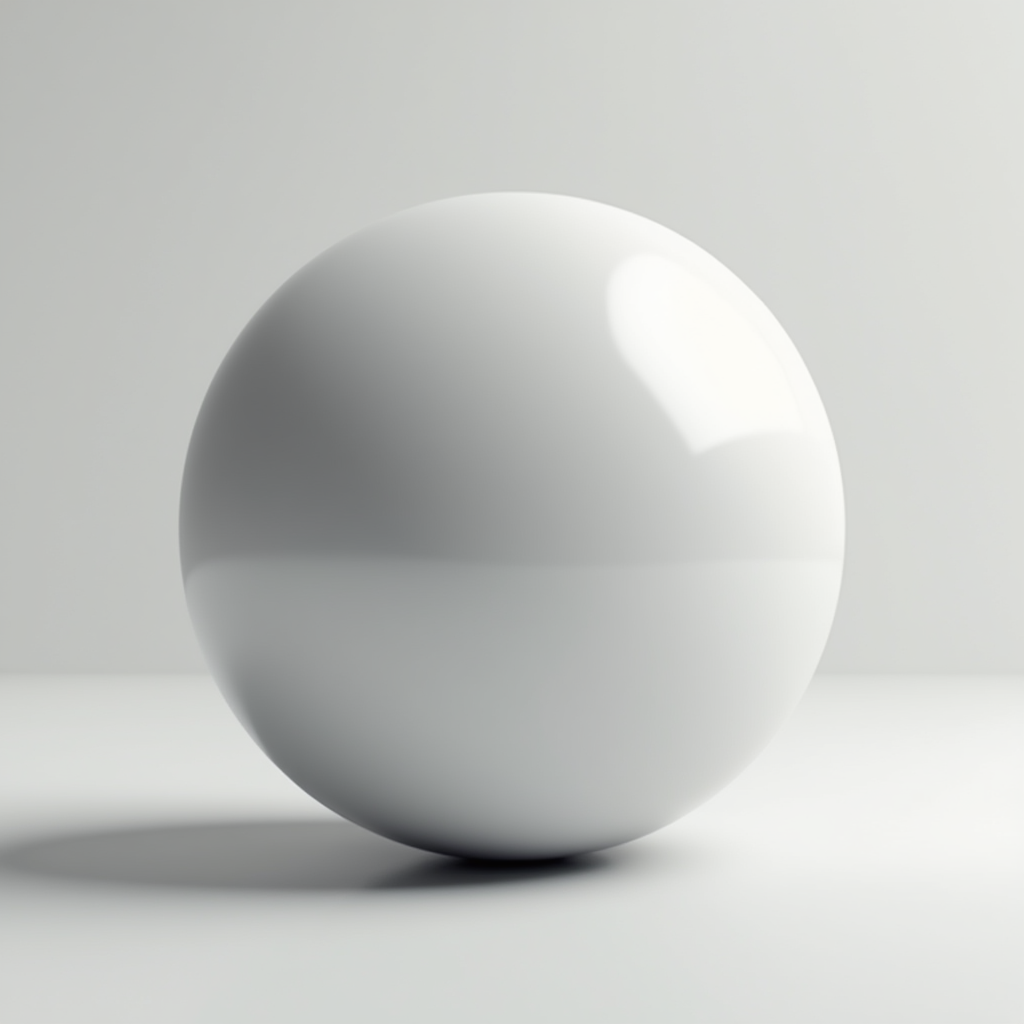

In [14]:
prompt = "a photo of a ball"

print(prompt)
print('-' * 10)
output_dict = inferencer(text=prompt, think=True, **inference_hyper)
print(output_dict['text'])
display(output_dict['image'])